<a href="https://colab.research.google.com/github/jiobu1/DS-Unit-2-Applied-Modeling/blob/master/Jisha_Obukwelu_DSPT3_233_Model_Interpretation_1_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Model Interpretation 1

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

If you have not yet completed an initial model yet for your portfolio project, you can do today's assignment using your Tanzania Waterpumps model. An example solution will be provided.

**Multi-class classification** will result in multiple Partial Dependence Plots (one for each class).

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
from google.colab import files
upload = files.upload()

Saving all_states.csv to all_states.csv


In [0]:
import pandas as pd
import numpy as np

In [0]:
all_states = pd.read_csv('all_states.csv')

###***Data cleaning, exploration, feature engineering, modeling***

#### Train_Val_Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train = all_states[all_states['YEAR'] <= 2011]
test = all_states[all_states['YEAR'] > 2011]

In [20]:
train, val = train_test_split(
    train, train_size=0.80, test_size=0.20,
    stratify=train['READING_PROF_8'], 
    random_state=42
)

train.shape, val.shape, test.shape

((928, 27), (233, 27), (331, 27))

#### Data cleaning, exploration, feature engineering

In [21]:
def wrangle(X):
  # Prevent SettingWithCopyWarning
  X = X.copy()

  # When columns have zeros and shouldn't, they are like null values.
  # So we will replace the zeros with nulls, and impute missing values later.
  cols_with_zeros = ['READING_PROF_8', 'MATH_PROF_8']
  for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan) 

  #Dropping rows if they do not contain any score data, will not drop if there is just 1 value
  X = X.dropna(axis=0, subset=['AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE'], thresh=1)

  #Return the wrangled dataframe
  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test) 

train.shape, val.shape, test.shape

((319, 27), (84, 27), (153, 27))

####Baseline

In [22]:
train['READING_PROF_8'].value_counts(normalize=True)

mid-basic     0.495298
low-basic     0.272727
0             0.134796
high-basic    0.097179
Name: READING_PROF_8, dtype: float64

In [23]:
train['READING_PROF_8'].value_counts()

mid-basic     158
low-basic      87
0              43
high-basic     31
Name: READING_PROF_8, dtype: int64

#### Modeling

##### X and Y

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [0]:
# Arrange data into X features matrix and y target vector

target = 'READING_PROF_8'
X_train = train.drop(columns = target)
y_train = train[target].astype(str)
X_val = val.drop(columns = target)
y_val = val[target].astype(str)
X_test = test

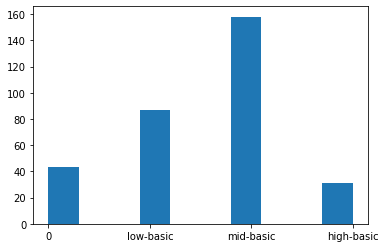

In [26]:
#Distribution of the scores
plt.hist(y_train);

##### XGBOOST

In [0]:
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.metrics import accuracy_score

In [0]:
drop = ['READING_PROF_8','MATH_PROF_8','AVG_MATH_4_SCORE','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE']

In [0]:
X_train = train.drop(columns = drop)
X_val = val.drop(columns=drop)
X_test = test.drop(columns=drop)

In [33]:
xg = make_pipeline(
    ce.BinaryEncoder(),   
    XGBClassifier(max_depth=6, eta=0.3, n_estimators=1000, 
                  n_jobs=-1, min_child_weight=1, subsample=0.9, 
                  colsample_bytree=0.9, objective='multi:softmax', 
                  eval_metric='merror', gamma=0, scale_pos_weight=1, 
                  seed=42)
)

# Fit on train
xg.fit(X_train, y_train)

# Score on val
print('Train Accuracy:', xg.score(X_train, y_train))
print('Validation Accuracy:', xg.score(X_val, y_val))

Train Accuracy: 1.0
Validation Accuracy: 0.5714285714285714


#### Feature Importances

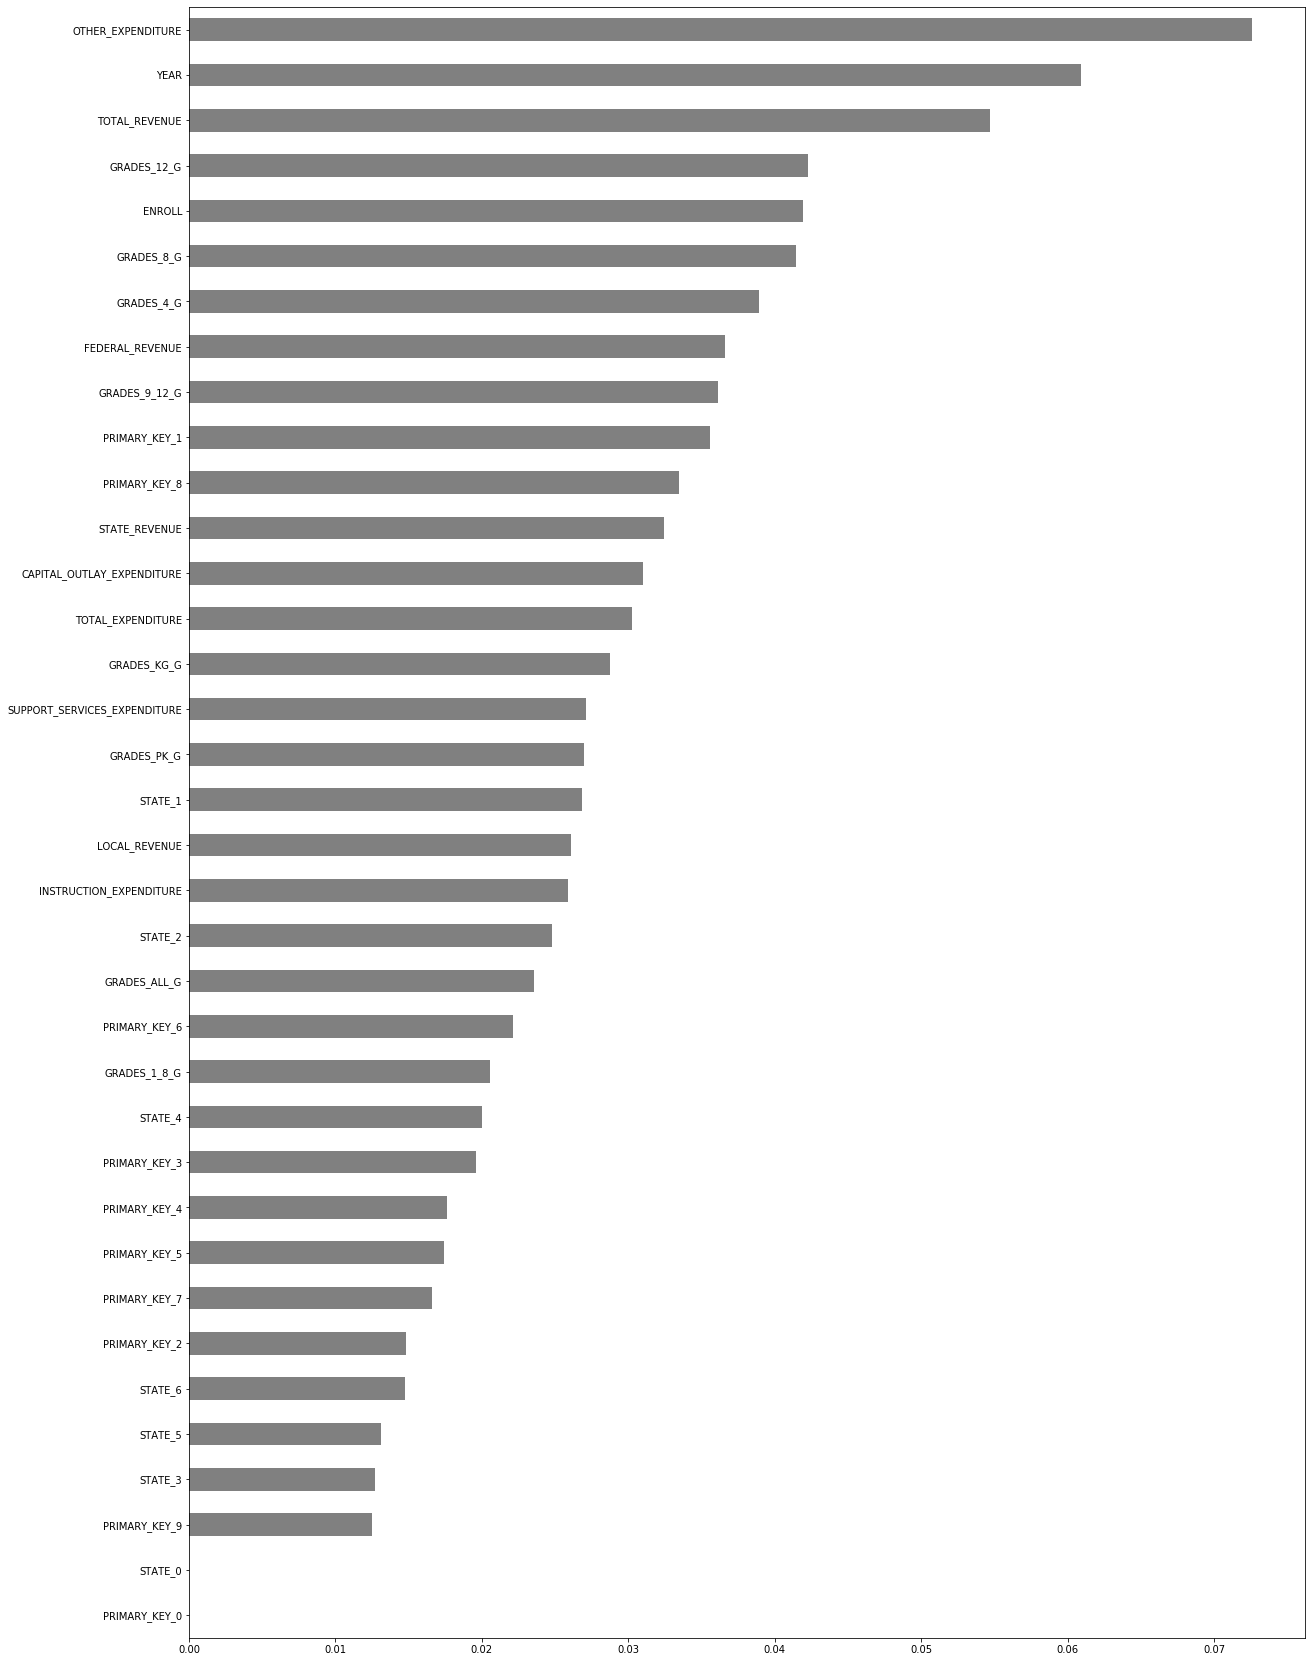

In [34]:
# Plot the feature importances
model = xg.named_steps['xgbclassifier']
encoder = xg.named_steps['binaryencoder']
encoded_columns = encoder.fit_transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(20,30))
importances.sort_values().plot.barh(color='grey');

###***Make at least 1 partial dependence plot to explain your model.***

In [0]:
plt.rcParams['figure.dpi'] = 72

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [37]:
X_train.columns

Index(['PRIMARY_KEY', 'STATE', 'YEAR', 'ENROLL', 'TOTAL_REVENUE',
       'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE',
       'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G'],
      dtype='object')

In [38]:
min(X_train['INSTRUCTION_EXPENDITURE']), max(X_train['INSTRUCTION_EXPENDITURE'])

(315009.0, 35617964.0)

In [0]:
feature = 'INSTRUCTION_EXPENDITURE'

isolated = pdp_isolate(
    model = xg, 
    dataset = X_val, 
    model_features = X_val.columns, 
    feature = feature
)

(<Figure size 1080x1080 with 5 Axes>,
 {'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7f8f895db668>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8f89676748>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


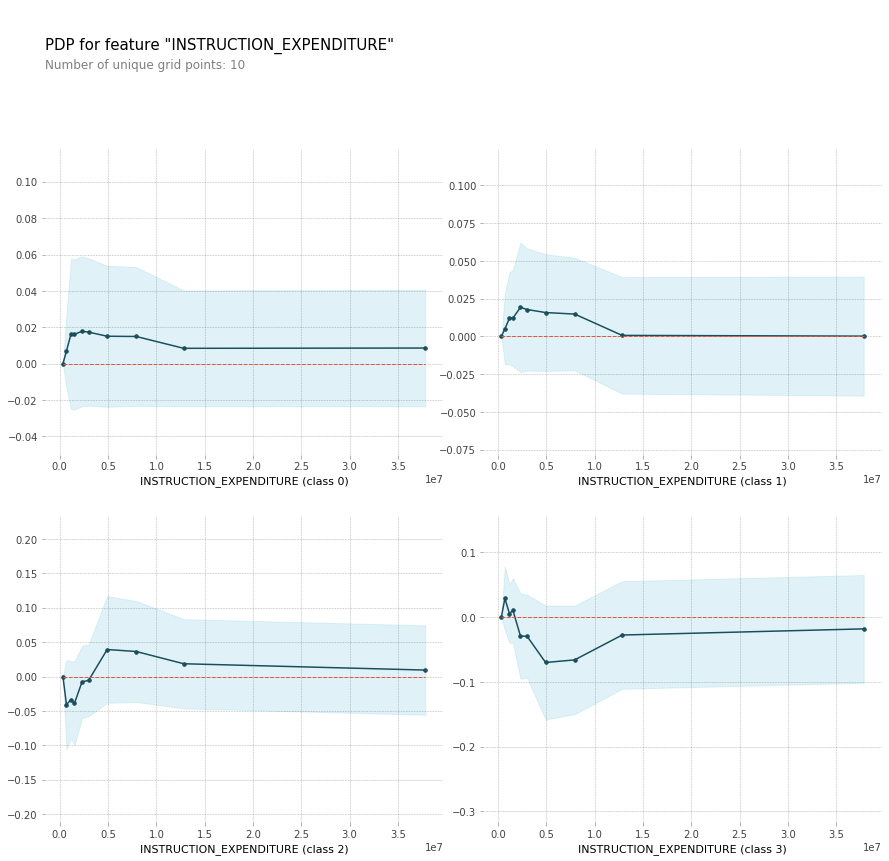

In [40]:
pdp_plot(isolated, feature_name = feature)

(0, 5)

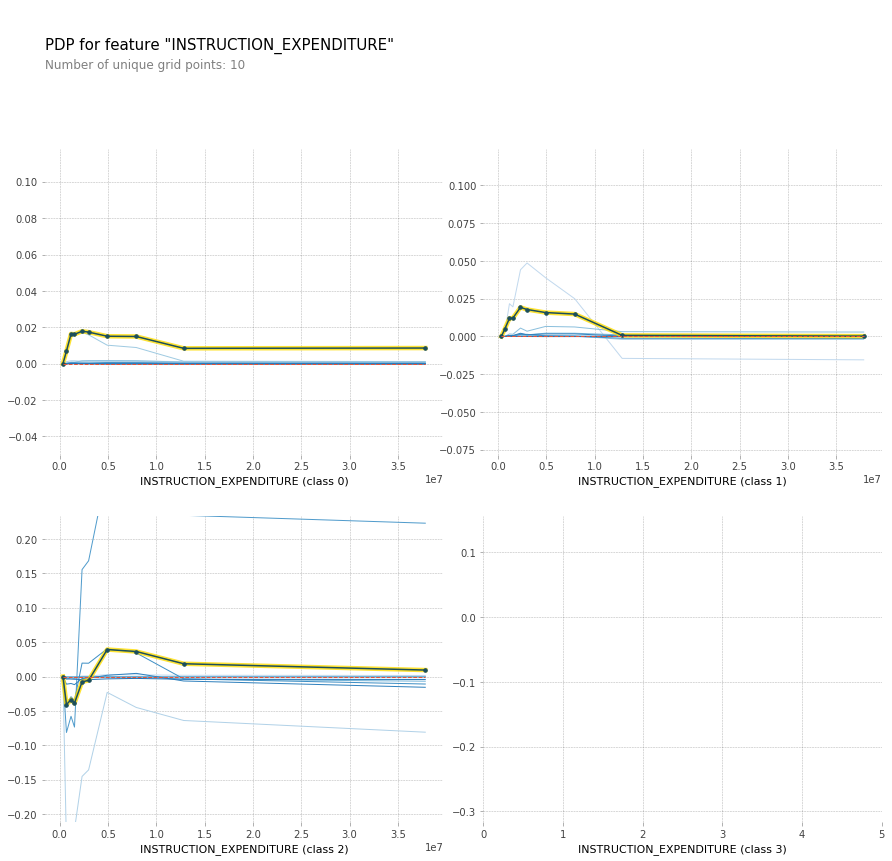

In [54]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=10)
plt.xlim(0, 5)

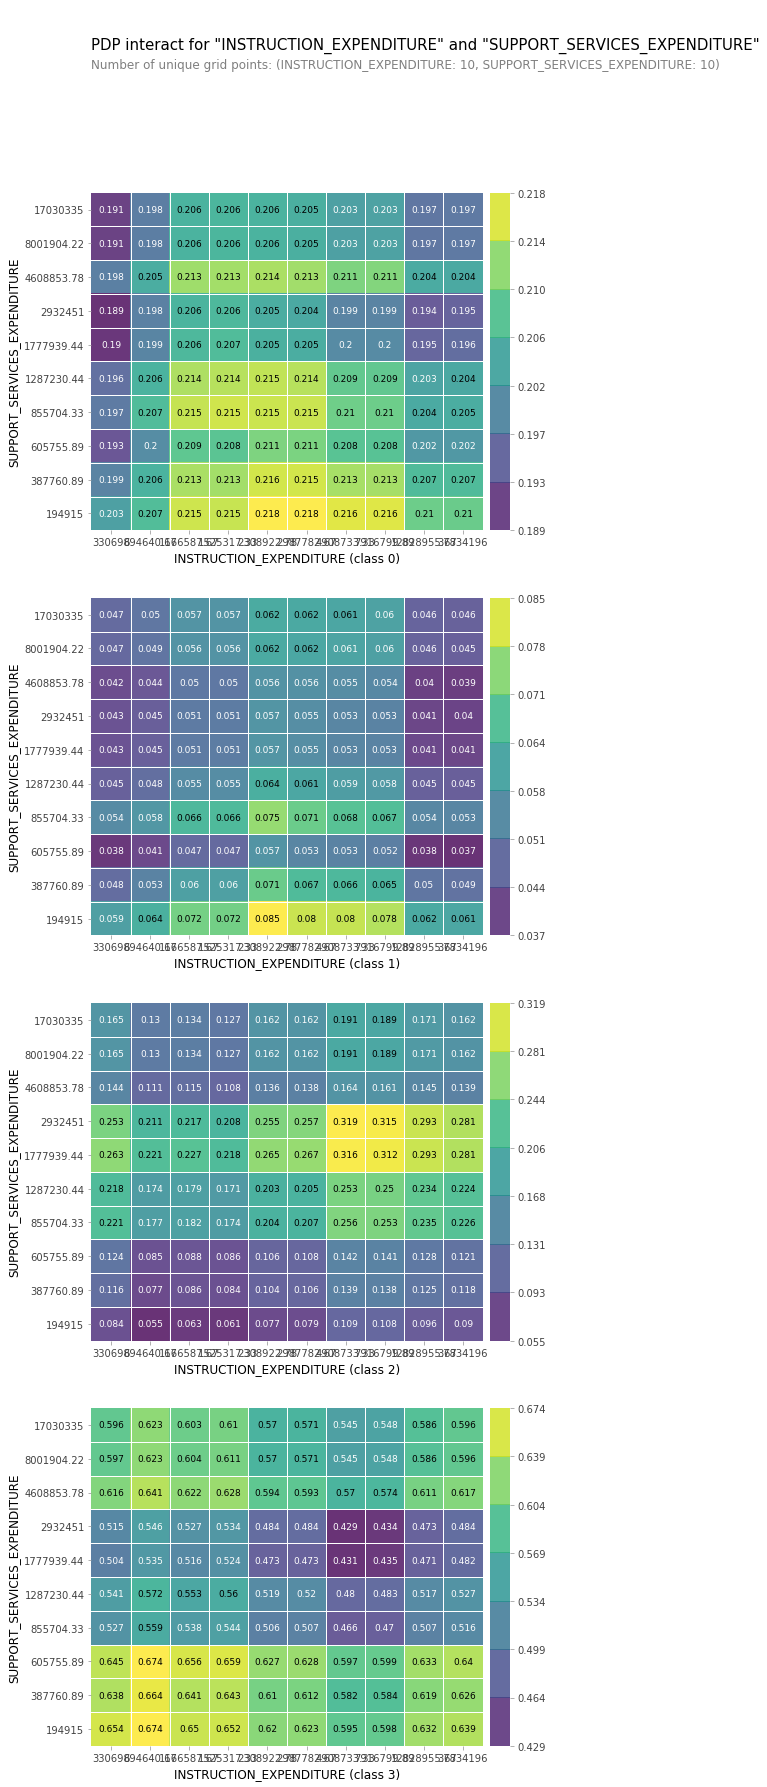

In [50]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features=['INSTRUCTION_EXPENDITURE','SUPPORT_SERVICES_EXPENDITURE']

interaction = pdp_interact(
    model=xg,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, 
                  plot_type='grid', 
                  feature_names=features, 
                  ncols=1, 
                  );

In [0]:
# pdp = interaction.pdp.pivot_table(
#     values='?',
#     columns=features[0],
#     index=features[1]
# )

# plt.figure(figsize=(10,6))
# sns.heatmap(pdp, annot=True, fmt='.2f')
# plt.title('2-D Partial Dependence of 8th Grade Student Proficiency on Instruction and Support Services Expenditure')

###***Use Plotly to make a 3D PDP.***